# **Wilkommen zur interaktiven Vorlesung zum Thema "Budyko und die klimatische Wasserbilanz"**

**Sebastian Gnann, Daniel Kretschmer, Thorsten Wagener**

#### Universität Potsdam

Die Online-Vorlesung basiert auf einem sogenannten Jupyter Notebook (https://jupyter.org/). 
Ein Notebook besteht aus einzelnen Zellen, die entweder Text oder Python-Code beinhalten.
In dieser Vorlesung sollen Sie sich durch die einzelnen Zellen klicken und interaktiv und mit echten Daten an das Thema herangeführt werden.

## Struktur der Vorlesung

I. Jupyter Notebooks: eine kurze Einführung

II. Budyko and die klimatische Wasserbilanz

III. Lösungsvorschläge und zusätzliche Informationen


# **I. Jupyter Notebooks: eine kurze Einführung**

### **Informationen zu Jupyer Notebooks**

Bitte lassen Sie das gesamte Notebook von vorne laufen, so dass alle Python-Module und die Daten in der richtigen Reihenfolge geladen werden.
Hierzu drücken Sie zuerst auf das "Restart the kernel" Symbol. 
Danach können Sie jeden Abschnitt ausführen indem Sie auf das "Run the selected cells and advance" Symbol klicken.
Nun können Sie sich Stück für Stück durch interaktive Vorlesung klicken. 

<img src="jupyter_explanation.png" alt="drawing" width=800/>

### **Informationen zu Python**

Python ist eine vielgenutzte Programmiersprache. Man kann Python-Code nun nutzen um Daten zu analysieren, Berechnungen anzustellen und Daten zu visualisieren.

Sie müssen selbst nicht programmieren, aber sich den Code anzuschauen hilft dabei zu verstehen, was genau in der Analyse passiert.
Kommentare werden mit einem # gekennzeichnet (sie werden nicht ausgeführt). 
Funktionen beginnen immer mit "def" und können auch eingeklappt werden, um die Lesbarkeit des Notebooks zu erhöhen.
Code wird meistens - wie die Programmiersprache selbst - auf Englisch geschrieben, so dass möglichst viele Leute den Code nutzen können.

Nachstehend sehen Sie ein kurzes Beispiel wie ein typischer Code-Schnipsel aufgebaut ist.


In [1]:
# define function that calculates the square of a number
def square(x):
    
    # define new variable y is the square of the number x
    y = x * x
    
    # this returns z to the user
    return y

# call function to calculate the square of 2
squared_value = square(2)

# print the resulting value
print("The resulting value is:", squared_value)

The resulting value is: 4


### **Notwendige Python Packages**
Es gibt verschieden sogenannte Packages für Python, die bestimme Funktionen ausführen. 
Manche Packages helfen beim Erstellen von Grafiken, andere erledigen bestimmte Rechenaufgaben.
Diese müssen am Anfang importiert werden. Wird das nicht gemacht, kann der nachstehende Code nicht ausgeführt werden.

In [2]:
# import all necessary Python packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from functions import helper_fcts
import ipywidgets as widgets

### **Information zu den Datensätzen**

Wir nutzen den sogenannten CAMELS US Datensatz (Newman et al., 2015; Addor et al., 2017).
CAMELS US ist ein Datensatz, der Daten für 671 Einzugsgebiete in den USA enthält. 
Für jedes Einzugsgebiet enthalten die Datensätze Zeitreihen von Niederschlag, Abfluss, potenzieller Verdunstung, etc., sowie Einzugsgebietseigenschaften wie die Größe des Einzugsgebiets oder die topographische Höhe.

todo: Karte Daten, Einzugsgebietzeichnung mit Fluss und Variablen
definition von allen Variablen
link zu Wiki

Hinschreiben: Annahmen von Hydro Basics werden erwartet und gute Mathe skills

**Quellen**

Newman, A. J., Clark, M. P., Sampson, K., Wood, A., Hay, L. E., Bock, A., ... & Duan, Q. (2015). Development of a large-sample watershed-scale hydrometeorological data set for the contiguous USA: data set characteristics and assessment of regional variability in hydrologic model performance. Hydrology and Earth System Sciences, 19(1), 209-223.

Addor, N., Newman, A. J., Mizukami, N., & Clark, M. P. (2017). The CAMELS data set: catchment attributes and meteorology for large-sample studies. Hydrology and Earth System Sciences, 21(10), 5293-5313.

In [3]:
# load data into workspace
df = pd.read_csv("results/camels_US_processed.csv")

# todo: calculate all attributes in code and also change names to German

# todo: add US map

# calculate aridity and climatic water balance 
df["aridity_class"] = 0 # assign aridity class (0 = energy-limited, 1 = water-limited)
df.loc[df["aridity"] > 1, "aridity_class"] = 1
df["climatic_water_balance"] = df["precipitation"] - df["pet"] # climatic water balance is defined as PET - P

# **II. Budyko and die klimatische Wasserbilanz**

Dieser Abschnitt beinhaltet den Kern der Vorlesung, inklusive Hintergrund, Theorie, sowie interaktive Datenanalyse und Visualisierung.
Im Laufe der Notebooks werden verschiedene <span style="color:DarkPurple">**Fragen**</span> gestellt, die Sie beantworten sollen um die <span style="color:DarkRed">**Lernziele**</span> zu erreichen.



**Übersicht**

1. Einführung
2. Die klimatische Wasserbilanz 
3. Die Budyko-Kurve
4. Abweichungen von der Budyko-Kurve
5. Die Wasserbilanz für verschiedene Jahre

## **1. Einführung**

<span style="color:DarkRed">**Lernziel**: *Sie sollten die wichtigsten Kenngrößen der klimatischen Wasserbilanz kennen und den Zusammenhang zwischen Wasser- und Energiebilanz erläutern können.*</span>

### **1.1 Mikhail Ivanovich Budyko (20.01.1920 – 10.12.2001)**

In den Jahren 1955-1974 studierte Mikhail Budyko ([Bildquelle mit Biographie](https://public.wmo.int/en/about-us/awards/international-meteorological-organization-imo-prize/mikhail-ivanovich-budyko)) im Rahmen seiner Forschungen die Komponenten der Land- und Meeresenergiebilanz, was in Russland und darüber hinaus weithin anerkannt wurde und den Grundstein für einen neuen Bereich der Meteorologie legte - die physikalische Klimatologie (Theorie des Klimas). 

<img src="https://ane4bf-datap1.s3-eu-west-1.amazonaws.com/wmocms/s3fs-public/styles/featured_media_detail/public/advanced_page/featured_media/Budyko.png?sVsiFNvfuHQf792994VKiDrakKn_AGLD&itok=bpEQF8dL" alt="drawing" width="300"/>


### **1.2 Die langfristige Wasserbilanz eines Einzugsgebiets**
Budyko nimmt an, dass die Wasserbilanz großer Einzugsgebiete ($\gg$1000 km²) nur vom Klima kontrolliert wird. 
Die langfristige Wasserbilanz für ein Einzugsgebiet ist dann:

\begin{equation}
\tag{1}
P = AET + Q \label{water_balance}
\end{equation}

wobei $P$ den Niederschlag beschreibt, $AET$ die tatsächliche Verdunstung und $Q$ den Abfluss (alle in mm/y).

Und die Energiebilanz ist:

\begin{equation}
\tag{2}
R_n = L + H + G \label{energy_balance}
\end{equation}

wobei $R_n$ die Nettostrahlung beschreibt, $L$ die latente Wärme, $H$ die sensible Wärme und $G$ den Bodenwärmefluss (alle in W/m²).

### **1.3 Der Zusammenhang zwischen Wasser- und Energiebilanz**

Die latente Wärme kann auch über die tatsächliche Verdunstung ausgedrückt werden:

\begin{equation}
\tag{3}
L = \lambda_w AET \label{latent_heat}
\end{equation}

wobei $\lambda_w$ die Verdunstungsenthalpie ist, also die Menge an Energie, die es braucht um eine bestimmte Menge an Wasser zu verdampfen (diese ist leicht abhängig von der Temperatur $T$). 

Die sogenannte potentielle Verdunstung $PET$ kann über die Nettostrahlung genähert werden:

\begin{equation}
\tag{4}
PET = \frac{R_n}{\lambda_w} \label{potential_evaporation}
\end{equation}

Der Bodenwärmestrom wird häufig vernachlässigt, so dass sich folgende Gleichung ergibt:

\begin{equation}
\tag{5}
R_n = \lambda_w AET + H \label{energy_and_water_balance}
\end{equation}

Gleichung (5) verbindet nun also die Wasserbilanz mit der Energiebilanz und ist somit eine wichtige Grundlage der Hydroklimatologie.

Link und Bild?

todo: leichte und schwere Frage?

<span style="color:DarkBlue">**Frage**: *Heutzutage wird häufig vom Konzept "Schwammstadt" gesprochen: es soll mehr Wasser in den Städten zurückgehalten werden. Was passiert mit der Nettostrahlung (Gleichung 5), wenn mehr Wasser zu Verfügung steht und was hat das für einen Einfluss auf das Stadtklima (z.B. die Temperatur)?*</span>

## **2. Die klimatische Wasserbilanz** 

<span style="color:DarkRed">**Lernziel**: *Sie sollten erklären können, was die klimatische Wasserbilanz ist und wieso die Einteilung von Einzugsgebieten in wasser- und energie-limitiert nützlich ist.*</span>

### **2.1 Der Trockenheitsindex**
Die klimatische Wasserbilanz ist definiert als $P - PET$.
Sie ist eng verwandt mit dem sogenannten Trockenheitsindex $\phi$ (manchmal auch Aridität genannt):

\begin{equation}
\tag{6}
\phi = \frac{PET}{P} \label{aridity_index}
\end{equation}

### **2.2 Energie- und wasser-limitierte Gebiete**
Gebiete, in denen $P$ größer als $PET$ (bzw. $\phi < 1$) ist, werden als **energie-limitiert** bezeichnet. 
In energie-limitierten Gebieten kann (fast) alle Energie genutzt werden ($PET \approx AET$).

Gebiete, in denen $P$ kleiner als $PET$ (bzw. $\phi > 1$) ist, werden als **wasser-limitiert** bezeichnet.
In solchen Gebieten kann nicht alle Energie genutzt werden um Wasser zu verdunsten, da nicht genügend Wasser vorhanden ist. 
Die Energie, die nicht genutzt wird um Wasser zu verdunsten, wird in fühlbare Wärme $H$ umgewandelt.


### **2.3 Der Zusammenhang zwischen klimatischer Wasserbilanz und Abfluss**
Im folgenden sehen Sie einen Plot, der den Abfluss gegen die klimatische Wasserbilanz zeigt. 

todo: klare anweisungen, z.b. 2 Unterschiede
<span style="color:DarkBlue">**Frage**: *Wie unterschieden... wasser- und energie-limitierten Gebieten? Wenn ja, können Sie diese erklären?*</span>

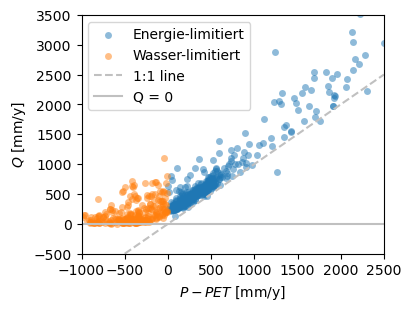

In [4]:
# define function that plots the climatic water balance against streamflow
def plot_climatic_water_balance(*args):
        
    # create figure
    fig = plt.figure(figsize=(4, 3), constrained_layout=True) 
    axes = plt.axes()
    
    # calculate correlation for energy- and water-limited catchments
    #r_sp_energy_limited, _ = stats.spearmanr(df.loc[df["aridity_class"] == 0, "climatic_water_balance"], 
    #                                         df.loc[df["aridity_class"] == 0, "streamflow"], nan_policy='omit')
    #r_sp_water_limited, _ = stats.spearmanr(df.loc[df["aridity_class"] == 1, "climatic_water_balance"],
    #                                        df.loc[df["aridity_class"] == 1, "streamflow"], nan_policy='omit')
    
    # plot climatic water balance against streamflow separated into energy- and water-limited catchments
    # to get annual values we multiply the daily values by 365
    im = axes.scatter(df.loc[df["aridity_class"] == 0, "climatic_water_balance"]*365, 
                      df.loc[df["aridity_class"] == 0, "streamflow"]*365,
                      s=25, c="tab:blue", alpha=0.5, lw=0, label='Energie-limitiert')#, 
                      #label=r"$PET/P < 1$; $\rho_s$ = " + str(np.round(r_sp_energy_limited,2))
    im = axes.scatter(df.loc[df["aridity_class"] == 1, "climatic_water_balance"]*365, 
                      df.loc[df["aridity_class"] == 1, "streamflow"]*365,
                      s=25, c="tab:orange", alpha=0.5, lw=0, label='Wasser-limitiert')#,
                      #label=r"$PET/P > 1$; $\rho_s$ = " + str(np.round(r_sp_water_limited,2))
    
    # plot 1:1 lineand horizontal line at y=0
    axes.axline((0, 0), slope=1, c='silver', label='1:1 line', linestyle='--')
    axes.axhline(c='silver', label='Q = 0')
    
    # specify axes, labels, etc.
    axes.set_xlabel("$P - PET$ [mm/y]")
    axes.set_ylabel("$Q$ [mm/y]")
    axes.set_xlim([-1000, 2500])
    axes.set_ylim([-500, 3500])
    axes.legend(loc='best')
    #axes.set_aspect('equal', adjustable='box')
    #axes.grid()
    
# run the function
plot_climatic_water_balance()
    
%matplotlib inline

## **3. Die Budyko-Kurve**

<span style="color:DarkRed">**Lernziel**: *Sie sollten die Herleitung der Budyko-Kurve erläutern können und erkären können, weshalb manche Einzugsgebiete außerhalb der Limits liegen.*</span>

### **3.1 Das Energie- und das Wasser-Limit als Grundlage der Budyko-Kurve**
Die Unterteilung in wasser- und energielimitiert bildet die Grundlage von Budykos Kurve. 

In energie-limitierten Gebieten (z.B. feuchte Gebiete wie Schottland oder Schweden) nähert sich die tatsächliche Verdunstung der potentiellen Verdunstung an.

\begin{equation}
%\tag{}
AET \rightarrow PET \label{}
\end{equation}

In wasser-limitierten Gebieten (z.B. trockene Gebiete wie Südspanien oder die Sahara) nähert sich die Verdunstung dem Niederschlag an.

\begin{equation}
%\tag{}
AET \rightarrow P \label{}
\end{equation}

Wir definieren nun neben dem Trockenheitsindex noch den sogenannten Verdunstungsindex:

\begin{equation}
\tag{7}
\psi = \frac{AET}{P} \label{evaporative_faction}
\end{equation}

Für zunehmend energie-limitierte ("humide") Gebiete, nähert sich der Verdunstungsindex dem Trockenheitsindex an, da alle Energie für die Verdunstung genutzt wird.
Für zunehmend wasser-limitierte ("aride") Gebiete, nähert sich der Verdunstungsindex 1 an, da der ganze Niederschlag verdunstet.

### **3.2 Budykos ursprüngliche Kurve**
Bildet man nun den Verdunstungsindex als Funktion des Trockenheitsindex ab, so ist der Verdunstungsindex für humide Gebiete von der vorhandenen Energie limitiert und für aride Gebiete vom vorhandenen Wasser limitiert. 
 
Budyko hat nun den Trockenheitsindex und den Verdunstungsindex von echten Einzugsgebieten geneinander aufgetragen und festgestellt, dass die Einzugsgebiete einer Kurve folgen.
Diese Kurve hat er, basierend auf Ergebnissen früherer Forschungsarbeiten anderer Forscher, mit der folgenden Formel genähert:

\begin{equation}
\tag{8}
\psi = [\phi \tanh(1/\phi) (1 - \exp(-\phi))]^{1/2} \label{budyko_equation}
\end{equation}

Diese Formel entspricht einer Kurve, die sich dem Energie- bzw. Wasserlimit annähert und gut zu den von Budyko untersuchten Einzugsgebieten passt, ist aber rein empirisch. Die unten gezeigte Grafik zeigt das Energie- bzw. Wasserlimit sowie Budykos Kurve.

<img src="Budyko_curve.png" alt="drawing" width="400"/>

### **3.3 Echte Einzugsgebietsdaten im "Budyko-Raum"**
Nun schauen wir uns das ganze mit echten Daten an. Wir nutzen 671 Einzugsgebiete aus dem CAMELS-Datensatz, der oben vorgestellt wurde.
Da es normalerweise keine direkten Messungen der Verdunstung in einem Einzugsgebiet gibt, nutzen wir Abflussdaten, die wir mithilfe von Gleichung (1) in Verdunstung umrechnen ($AET = P - Q$).

\begin{equation}
\tag{9}
\psi = \frac{AET}{P} = \frac{P - Q}{P} = 1 - \frac{Q}{P}  \label{evaporative_fraction_using_Q}
\end{equation}


Der unten angezeigte Plot zeigt, dass die meisten Datenpunkte den von Budyko postulierten Grenzen folgen. Die Kurve passt zwar nicht perfekt, gibt aber den generellen Trend gut wieder. Es ist wichtig zu beachten, dass diese Daten unabhängig von den von Budyko genutzten Daten sind.

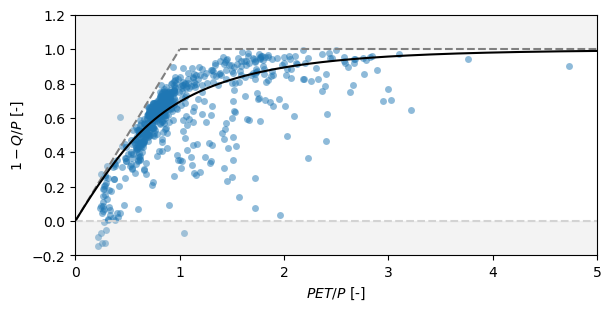

In [5]:
def plot_Budyko(plot_curve=False,*args):
    
    # create figure
    fig = plt.figure(figsize=(6, 3), constrained_layout=True)
    axes = plt.axes()
    
    # plot catchments in Budyko space
    im = axes.scatter(df["aridity"], 1-df["runoff_ratio"], s=25, alpha=0.5, lw=0) 
    
    # specify axes, labels, etc.
    axes.set_xlabel("$PET/P$ [-]")
    axes.set_ylabel("$1 - Q/P$ [-]")
    axes.set_xlim([0, 5])
    axes.set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes)
    #axes.set_xscale('log')
    
    # plot Budyko curve
    if plot_curve == True:
        helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes)

# this function plots catchments in Budyko space as well as the Budyko curve
plot_Budyko(plot_curve=True) 

#todo: points outside limits as crosses and remove later + question why?

%matplotlib inline

<span style="color:DarkBlue">**Frage**: *Manche Punkte liegen außerhalb der theoretischen Grenzen (im grauen Bereich). Welche Gründe könnte es dafür geben?*</span>

**Hinweis**: Im folgenden werden wir diese Punkte nicht mehr betrachten, sondern uns auf die Punkte innerhalb der Limits konzentrieren.

In [6]:
# remove points outside limits
df.loc[np.logical_or((1-df["runoff_ratio"])<0,(1-df["runoff_ratio"])>df["aridity"])] = np.nan

## **4. Abweichungen von der Budyko-Kurve**

<span style="color:DarkRed">**Lernziel**: *Sie sollten verschiedene Gründe für die Abweichung der Budyko-Kurve nennen können und diskutieren können, welche Gründe für bestimmte Gebiete plausibel sind.*</span>

### **4.1 Quantifizierung der Abweichung**
Wie man sehen kann, liegen nicht alle Einzugsgebiete auf der Budyko-Kurve. Abgesehen von Unsicherheiten in den Daten, welche Gründe könnte es für eine Abweichung von der Linie geben? Um diese Frage zu beantworten, wollen wir zuerst die Abweichungen von der Kurve quantifizieren. 

Hierzu berechnen wir für jedes Einzugsgebiet den Verdunstungsindex basierend auf Budykos Kurve indem wir den Trockenheitsindex des Einzugsgebiets in Gleichung (8) einsetzen.

Nun können wir den tatsächlichen Verdunstungsindex (genähert als $1 - Q/P$) mit dem berechneten Verdunstungsindex (Gleichung 8) vergleichen. Wir berechnen die Differenz der beiden Werte, die sogenannte Budyko-Anomalie. Je weiter der Wert unterhalb der Kurve ist, desto negativer ist er und je weiter der Wert oberhalb der Kurve ist, desto positiver ist er. Das können Sie in der folgenden Grafik sehen.


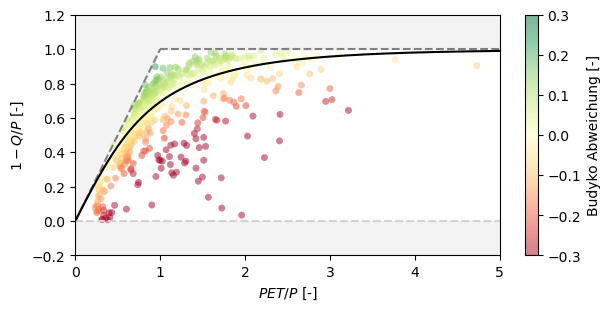

In [14]:
# define function that creates a Budyko plot coloured according to Budyko anomalies
def plot_Budyko_anomaly(*args):
    
    #todo: add dict for z name and unit
    
    # create figure
    fig = plt.figure(figsize=(6, 3), constrained_layout=True)
    axes = plt.axes()
    
    # plot catchments in Budyko space coloured according to Budyko anomalies
    im = axes.scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c=df["Budyko_anomaly"], alpha=0.5, lw=0, cmap='RdYlGn') 
    
    # specify axes, labels, etc.
    axes.set_xlabel("$PET/P$ [-]")
    axes.set_ylabel("$1 - Q/P$ [-]")
    axes.set_xlim([0, 5])
    axes.set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes)
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes)   
    #axes.set_xscale('log')
    cbar = fig.colorbar(im, ax=axes)
    cbar.set_label("Budyko Abweichung [-]")   
    cbar.mappable.set_clim(vmin=-0.3,vmax=0.3)

# calculate evaporative fraction using the Budyko equation and use it to calculate Budyko anomalies 
df["evaporative_fraction"] = helper_fcts.Budyko_curve(df["aridity"])
df["Budyko_anomaly"] = (1 - df["runoff_ratio"]) - df["evaporative_fraction"]

# run the function
plot_Budyko_anomaly()

%matplotlib inline

### **4.2 Gründe für Abweichungen von der Budyko-Kurve**

# todo: längere Beschreibung

<span style="color:DarkBlue">**Frage**: *Überlegen Sie sich mindestens drei Gründe (Hypothesen) für die Abweichungen von der Budyko-Kurve.*</span>

z.B. mithilfe einer AI (https://www.perplexity.ai/, https://openai.com/blog/chatgpt) 
todo: Definiere beide AIs kurz

todo: FEEDBACK ZU ÜBUNG: link

Im nächsten Teil werden sie diese Hypotheses zur Erklärung der Abweichungen mit Daten überprüfen.

Um herauszufinden, welche der oben genannten Gründe die Abweichungen verursachen könnten, können wir verschiedene Einzugsgebietseigenschaften nutzen.
Das sind Werte, die bestimmte Eigenschaften eines Einzugsgebiets zusammenfassen; z.B. die durchschnittliche Höhe, der Wald-Anteil, oder der Anteil an Regen, der als Schnee fällt.

Hier sollen Sie zwei Möglichkeiten nutzen, um die Gründe für Abweichungen von der Budyko-Kurve zu untersuchen. 
Zum einen kann man die Punkte im Budyko-Graph der Einzugsgebietseigenschaft entsprechend einfärben - daran lassen sich oft Muster erkennen.
Zum anderen kann man die Abweichungen von der Budyko-Kurve, wie wir sie vorhin berechnet haben, mit den Einzugsgebietseigenschaften vergleichen. 
Das geht sowohl graphisch als auch über die Korrelation. Diese beschreibt eine Beziehung zwischen zwei Variablen mit einem Wert zwischen -1 und 1.
Werte nahe 1 deuten einen starken Zusammenhang an. Werte nahe -1 deuten einen starken umgekehrter Zusammenhang an. Werte nahe 0 deuten an, dass kein Zusammenhang besteht.

Aber, wie man in jeder Statistikvorlesung lernt: Korrelation ist nicht gleich Kausalität. 
Deswegen sollten Sie sich auch Gedanken machen, welche Nachteile diese Art der Analyse hat und was für Lösungen es geben könnte.

Weitere Informationen finden Sie auch hier: https://en.wikipedia.org/wiki/Correlation 

In [15]:
# define function that creates Budyko plot coloured according to catchment attributes
def plot_Budyko_attributes(x):
    
    dict_names = {'gauge_id': 'Einzugsgebiets-ID',
              'p_seasonality': 'Saisonalität des Niederschlags [-]', 
              'frac_snow': 'Schnee-Anteil [-]', 
              'high_prec_freq': 'Anteil starker Niederschläge [%]',
              'frac_forest': 'Wald-Anteil [-]', 
              'slope_mean': 'Topographische Steigung [m km$^{-1}$]', 
              'elev_mean': 'Topographische Höhe [m]', 
              'soil_depth_pelletier': 'Bodentiefe [m]', 
              'clay_frac': 'Ton-Anteil [-]', 
              'carbonate_rocks_frac': 'Anteil Carbonatgestein [-]',       
              'geol_permeability': 'Geologische Durchlässigkeit [m²]'}
    #df.rename(columns=dict_names, inplace=True)
    
    dict_explantions = {'gauge_id': 'Einzugsgebiets-ID: eindeutige Nummer, die jedem Einzugsgebiet zugeordnet ist.',
              'p_seasonality': 'Saisonalität des Niederschlags [-]: negative (positive) Werte zeigen an, dass mehr Niederschlag im Winter (sommer) fällt.', 
              'frac_snow': 'Schnee-Anteil [-]: der Anteil des Niederschlags, der als Schnee fällt.', 
              'high_prec_freq': 'Häufigkeit niederschlagsreicher Tager [%]: Häufigkeit von niederschlagsreichen Tagen (≥ 5 mal mittlerer Tagesniederschlag).',
              'frac_forest': 'Wald-Anteil [-]: der Anteil des Einzugsgebiets, der mit Wald bedeckt ist.', 
              'slope_mean': 'Topographische Steigung [m/km]: die durchschnittliche topographische Steigung im Einzugebiet.', 
              'elev_mean': 'Topographische Höhe [m]: die durchschnittliche Höhe des Einzugsgebiets (über dem Meeresspiegel).', 
              'soil_depth_pelletier': 'Bodentiefe [m]: die durchschnittliche Tiefe des Bodens im Einzugsgebiet.', 
              'clay_frac': 'Ton-Anteil [-]: der durchschnittliche Anteil an Ton (sehr feinkörniges Sediment) im Boden des Einzugsbiets.', 
              'carbonate_rocks_frac': 'Anteil Carbonatgestein [-]: der Anteil des Einzugsgebiets, an dem Karbonatgestein vorkommt.',       
              'geol_permeability': 'Geologische Durchlässigkeit [m²]: durchschnittliche Durchlässigkeit des Geste'}
    
    print(dict_explantions[x])
    
    # create figure
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
    
    # plot catchments in Budyko space coloured according to catchment attribute
    im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c=df[x], alpha=0.5, lw=0) #, s=df["area"]/100
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes[0])
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    #axes.set_xscale('log')
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label(dict_names[x])    
    
    # calculate correlation
    r_sp, _ = stats.spearmanr(df[x], df["Budyko_anomaly"], nan_policy='omit')
    
    # plot vertical line at x = 0
    axes[1].axhline(c='lightgrey', linestyle='--')
    
    # plot catchment attribute against Budyko anomaly
    im = axes[1].scatter(df[x], df["Budyko_anomaly"], s=25, c=df["Budyko_anomaly"], alpha=0.5, lw=0, cmap='RdYlGn', 
                      label=r"$\rho_s$ = " + str(np.round(r_sp,2)))   
    
    # specify axes, labels, etc.
    axes[1].set_xlabel(dict_names[x])    
    axes[1].set_ylabel("Budyko Abweichung [-]")
    #axes[1].set_ylim([-1, 1])
    axes[1].legend(loc='best')
    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label("Budyko Abweichung [-]")   
    cbar.mappable.set_clim(vmin=-0.3,vmax=0.3)

# run the function
widgets.interact(plot_Budyko_attributes, x=[
                'gauge_id',
                'p_seasonality', 
                'frac_snow', 
                'high_prec_freq',
                'frac_forest', 
                'slope_mean', 
                'elev_mean', 
                'soil_depth_pelletier', 
                'clay_frac', 
                'carbonate_rocks_frac',       
                'geol_permeability'], 
                layout={'width': 'max-content'}, disabled=False)

#todo: add area and change names!

%matplotlib inline

interactive(children=(Dropdown(description='x', options=('gauge_id', 'p_seasonality', 'frac_snow', 'high_prec_…

### **4.3 Die Rolle der Einzugsgebietsgröße**

Budyko hat seine Theorie ursprünglich für große Einzugsbiete ($\gg$1000 km²) entwickelt.

todo: rausnehmen

<span style="color:DarkBlue">**Frage**: *Wieso spielt die Einzugsgebietsgröße eine Rolle?*</span>



In [9]:
# define function that highlights catchments in Budyko space depending on their size
def plot_Budyko_assumptions_size(x):
        
    # create figure
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
    
    # select catchments based on their size
    if x == 'x < 250':
        df_tmp = df.loc[(df["area_gages2"]<200)]
        
    elif x == '250 < x < 750':
        df_tmp = df.loc[np.logical_and(df["area_gages2"]>200,df["area_gages2"]<500)]
        
    elif x == 'x > 750':
        df_tmp = df.loc[(df["area_gages2"]>500)]
        
    else:
        print("Category not available.")
        
    # plot catchments in Budyko space and highlight them according to size
    im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c="lightgrey", alpha=1, lw=0) 
    im = axes[0].scatter(df_tmp["aridity"], 1-df_tmp["runoff_ratio"], s=25, c="tab:red", alpha=0.5, lw=0) 
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df_tmp["aridity"], df_tmp["runoff_ratio"], axes[0])
    #axes.set_xscale('log')
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    
    # plot histogram of all catchment areas
    im = axes[1].hist(df["area_gages2"], np.linspace(0,2000,40), facecolor="grey")
    
    # specify axes, labels, etc.
    axes[1].set_xlabel("Area [km$^2$]")
    axes[1].set_ylabel("Count")
    axes[1].set_xlim([0, 2000])

# run the function
widgets.interact(plot_Budyko_assumptions_size, x=['x < 250','250 < x < 750','x > 750'])

%matplotlib inline

interactive(children=(Dropdown(description='x', options=('x < 250', '250 < x < 750', 'x > 750'), value='x < 25…

## **5. Die Wasserbilanz für verschiedene Jahre**

<span style="color:DarkRed">**Lernziel**: *Sie sollten erklären können, wieso sich die Wasserbilanz von Jahr zu Jahr ändert und wie sich energie- und wasser-limitierte Gebiete verhalten.*</span>

### **5.1 Kürzere Zeitperioden: Variabilität von Jahr zu Jahr**

<span style="color:DarkBlue">**Frage**: *Schaut man sich kürzere Zeitperioden an, z.B. einzelne Jahre, so sind bestimmte Annahmen der Budyko-Kurve nicht mehr gegeben.
Welche sind das? Und wie kann man das mit Daten nachvollziehen?*</span>

In [17]:
# define function that highlights a single catchment in Budyko space and how it changes with time
def plot_Budyko_single_catchment(x):
        
    # create figure
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
    
    # todo: add info on selected catchments
    
    # select years
    years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
    aridity_tmp = np.zeros(len(years))
    runoff_ratio_tmp = np.zeros(len(years))
    precipitation_tmp = np.zeros(len(years))
    i = 0
    for year in years:
        aridity_tmp[i] = df.loc[df["gauge_id"]==x, "aridity"+'_'+year]
        runoff_ratio_tmp[i] = df.loc[df["gauge_id"]==x, "runoff_ratio"+'_'+year]
        precipitation_tmp[i] = df.loc[df["gauge_id"]==x, "precipitation"+'_'+year]
        i = i+1

    # plot catchments in Budyko space and highlight individual catchments
    im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c="lightgrey", alpha=1, lw=0, label='Alle Einzugsgebiete')
    im = axes[0].scatter(aridity_tmp, 1-runoff_ratio_tmp, marker='d', s=35, c='tab:orange', alpha=1.0, lw=0, label='Jährliche Werte Einzugsgebiet') 
    im = axes[0].scatter(df.loc[df["gauge_id"]==x, "aridity"], 1-df.loc[df["gauge_id"]==x, "runoff_ratio"], marker='d', s=35, c='black', alpha=1.0, lw=0, label='Mittelwert Einzugsgebiet') 
    #im = axes[0].scatter(aridity_tmp, 1-runoff_ratio_tmp, marker='d', s=35, c=np.array(years).astype(float), alpha=1.0, lw=0) 
    #im = axes[0].plot(aridity_tmp, 1-runoff_ratio_tmp, c='grey', alpha=0.75) 
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes[0])
    #axes.set_xscale('log')
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0]) 
    axes[0].legend(loc='best')
    
    # plot time series for individual catchments
    im = axes[1].plot(np.array(years).astype(float), aridity_tmp, c='tab:green', alpha=0.75, label='PET/P')   
    im = axes[1].plot(np.array(years).astype(float), 1-runoff_ratio_tmp, c='tab:blue', alpha=0.75, label='1-Q/P')   
    
    axes[1].axhline(c='silver', label='Q = 0')
    
    # specify axes, labels, etc.
    axes[1].set_xlabel("Year")    
    axes[1].set_ylabel("[-]")
    axes[1].legend(loc='best')
    
# run the function
widgets.interact(plot_Budyko_single_catchment, x=[1013500, 8196000, 11124500, 13023000, 14309500])

# add names of streams

# US map

# todo: use spider plot?

%matplotlib inline    

interactive(children=(Dropdown(description='x', options=(1013500, 8196000, 11124500, 13023000, 14309500), valu…

# **III. Lösungsvorschläge und zusätzliche Informationen**


### Klimatische Wasserbilanz und Abfluss
Der Zusammenhang zwischen der klimatischen Wasserbilanz und dem Abfluss ist sehr stark, inbesondere in energie-limitierten Gebieten.
Hier sollte $P - PET$ ungefähr $Q$ entsprechen, da genügend Wasser verfügbar ist und somit (fast) alle Energie für Verdunstung (d.h. $AET$) genutzt werden kann.
Der Zusammenhang ist allerdings nie perfekt. Zum einen sind Umweltdaten immer mit Unsicherheit behaftet. 
Zum anderen gibt es noch weitere Faktoren über die klimatische Wasserbilanz hinaus, die die Abflussbildung beeinflussen. Diese werden wir später erarbeiten.

### Abweichungen von der Budyko-Kurve
ChatGPT prompt: Überlegen Sie sich mindestens drei Gründe (Hypothesen) für die Abweichungen von der Budykokurve, in Tabellenform als markdown code

Antwort: Natürlich! Hier sind fünf Hypothesen für mögliche Abweichungen von der Budyko-Kurve in tabellarischer Form als Markdown-Code und bitte halten Sie es kurz:

| Nr. | Hypothese für Abweichungen von der Budyko-Kurve                |
|-----|------------------------------------------------------------|
|  1  | Einfluss lokal begrenzter geologischer Gegebenheiten        |
|  2  | Änderungen in der Landnutzung und Vegetationsbedeckung      |
|  3  | Regionale klimatische Unterschiede                          |
|  4  | Menschliche Eingriffe und Wassermanagement                  |
|  5  | Hydrologische Besonderheiten in spezifischen Gebieten       |

Schaut man sich langjährige Mittelwerte an, z.B. über 30 Jahre ("klimatologisches Mittel"), so wird es wahrscheinlicher, dass die Annahme zutrifft, dass keine Änderung des Speichers im Einzugsgebiet stattfindet. In einzelnen Jahren kann diese Änderung hingehen sehr groß sein und damit zu Abweichungen von der Budykokurve führen.


In [11]:
# define function that creates Budyko plots for different time periods
def plot_Budyko_assumptions_time(x):
    
    # calculate evaporative fraction and Budyko anomaly for subperiod
    df["evaporative_fraction"+'_'+x] = helper_fcts.Budyko_curve(df["aridity"])
    df["Budyko_anomaly"+'_'+x] = (1 - df["runoff_ratio"+'_'+x]) - df["evaporative_fraction"+'_'+x]
    
    # create figure
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    #axes = fig.subfigures(1, 2, wspace=0.07)
      
    # plot catchments for the whole period and for a selected time period in Budyko space
    im = axes[0].scatter(df["aridity"], 1-df["runoff_ratio"], s=25, c="lightgrey", alpha=1, lw=0) 
    im = axes[0].scatter(df["aridity"+'_'+x], 1-df["runoff_ratio"+'_'+x], s=25, c="tab:red", alpha=0.5, lw=0) 
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 5])
    axes[0].set_ylim([-0.2, 1.2])
    helper_fcts.plot_Budyko_limits(df["aridity"], df["runoff_ratio"], axes[0])
    #axes.set_xscale('log')
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    
    # plot histogram that shows Budyko anomalies for whole period and for selected time period
    df["Budyko_anomaly"+'_'+x] = (1 - df["runoff_ratio"+'_'+x]) - df["evaporative_fraction"+'_'+x]
    im = axes[1].hist(df["Budyko_anomaly"], np.linspace(-1,1,20), facecolor="grey", alpha=0.5, label='Alle Jahre')
    im = axes[1].hist(df["Budyko_anomaly"+'_'+x], np.linspace(-1,1,20), facecolor="tab:red", alpha=0.5, label=x)
    
    # specify axes, labels, etc.
    axes[1].set_xlabel("Budyko Abweichung [-]" )    
    axes[1].set_ylabel("Anzahl Einzugsgebiete")
    axes[1].set_xlim([-1, 1])
    axes[1].legend(loc='best')
    
# run the function
widgets.interact(plot_Budyko_assumptions_time, x=['2001','2002','2003','2004','2005','1980-1989','1990-1999','2000-2009'])

# move to appendix

%matplotlib inline

interactive(children=(Dropdown(description='x', options=('2001', '2002', '2003', '2004', '2005', '1980-1989', …

# **Zusatzbeispiel: die Rolle der Geologie am Beispiel England**

Nun schauen wir uns noch an wie Landschaftseigenschaften, wie z.B. die Geologie, die langfristige Wasserbilanz beeinflussen können.

In England zeigt sich ein besonders starker Kontrast. Viele Kreide-Gebiete haben sehr ergiebige Grundwasserleiter, wohingegen anderen Gebiete in England häufig wenig aktives Grundwasser aufweisen. 

Was könnte die Folge davon sein?


In [12]:
# load data into workspace
df_GB = pd.read_csv("results/camels_GB_processed.csv")

# calculate evaporative fraction using the Budyko equation and use it to calculate the Budyko anomaly
df_GB["evaporative_fraction"] = helper_fcts.Budyko_curve(df_GB["aridity"])
df_GB["Budyko_anomaly"] = (1 - df_GB["runoff_ratio"]) - df_GB["evaporative_fraction"]

# choose only benchmark catchments ("near-natural")
df_GB = df_GB.loc[df_GB["benchmark_catch"] == 'Y']

In [13]:
# define function that creates a Budyko plot for catchments in Great Britain
def plot_Budyko_attributes_GB(x):
    
    # create figure
    fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, nrows=1, ncols=2, gridspec_kw={'width_ratios': [2, 1]})
    
    # plot catchments in Budyko space coloured according to catchment attribute
    im = axes[0].scatter(df_GB["aridity"], 1-df_GB["runoff_ratio"], s=25, c=df_GB[x], alpha=0.5, lw=0) #, s=df_GB["area"]/100
    
    # specify axes, labels, etc.
    axes[0].set_xlabel("$PET/P$ [-]")
    axes[0].set_ylabel("$1 - Q/P$ [-]")
    axes[0].set_xlim([0, 1.2])
    axes[0].set_ylim([-0.6, 1.2])
    helper_fcts.plot_Budyko_limits(df_GB["aridity"], df_GB["runoff_ratio"], axes[0])
    helper_fcts.plot_Budyko_curve(np.linspace(0.01,10,1000), axes[0])
    #axes.set_xscale('log')
    cbar = fig.colorbar(im, ax=axes[0])
    #cbar.set_label(dict_names[x])    
    
    # calculate correlation
    r_sp, _ = stats.spearmanr(df_GB[x], df_GB["Budyko_anomaly"], nan_policy='omit')    
    
    # plot vertical line at x = 0
    axes[1].axhline(c='lightgrey', linestyle='--')
    
    # plot catchment attribute against Budyko anomaly
    im = axes[1].scatter(df_GB[x], df_GB["Budyko_anomaly"], s=25, c=df_GB["Budyko_anomaly"], alpha=0.5, lw=0, cmap='RdYlGn', 
                      label=r"$\rho_s$ = " + str(np.round(r_sp,2)))   
    
    # specify axes, labels, etc.
    #axes[1].set_xlabel(dict_names[x])  
    axes[1].set_ylim([-1, 1])  
    axes[1].set_ylabel("Budyko Abweichung [-]")
    axes[1].legend(loc='best')
    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label("Budyko Abweichung [-]")   
    cbar.mappable.set_clim(vmin=-0.3,vmax=0.3)

# todo: rename attributes  
# todo: add attributes that do not matter 

    
"""
dict_names = {'frac_high_perc': '% Grundwasserleiter hoch',
                  'frac_low_perc': '% Grundwasserleiter niedrig',
                  'no_gw_perc': '% kein Grundwasserleiter',
                  'baseflow_index': 'BFI'}
"""
    
# run the function
widgets.interact(plot_Budyko_attributes_GB, x=['soil_depth_pelletier', 'clay_perc', 'conductivity_cosby',
                                               'frac_high_perc', 'inter_high_perc', 'no_gw_perc', 'baseflow_index_ceh',
                                               'reservoir_cap', 'groundwater_abs', 'surfacewater_abs', 'discharges'])

%matplotlib inline

interactive(children=(Dropdown(description='x', options=('soil_depth_pelletier', 'clay_perc', 'conductivity_co…